In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Saved to 01_colorsorting.svg


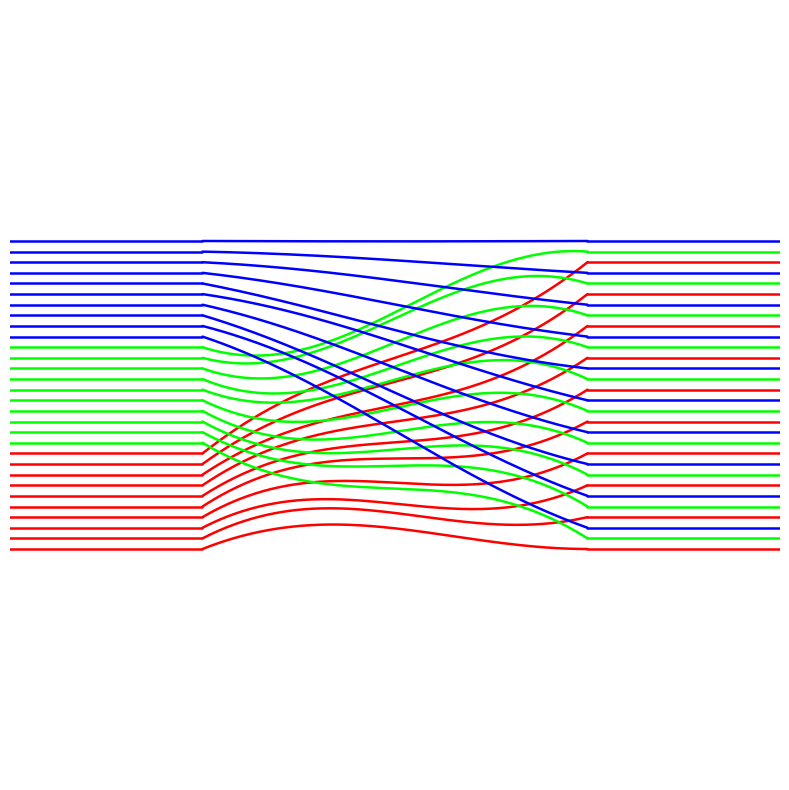

In [9]:
# Line art: 3 colors, 3x10 left grouped by color, right alternating RGB, connected in the middle
# Saves an SVG and shows the plot

import numpy as np
import matplotlib.pyplot as plt

# -------- parameters --------
NUM_PER_COLOR = 10
COLORS = [("red", (1,0,0)), ("green", (0,1,0)), ("blue", (0,0,1))]
LEFT_X  = 0.0       # x of left short horizontal bars
RIGHT_X = 1.00       # x of right short horizontal bars
SEG_W   = 0.5       # length of the short horizontal bars
MARGIN_Y = 0.3      # top and bottom margin
RANDOM_SEED = 7      # for reproducible gentle wiggles
LINEWIDTH = 1.8
FIGSIZE = (12, 8)
OUTFILE = "01_colorsorting.svg"

# -------- build ordering --------
# Left order: 10 red, 10 green, 10 blue
left_order = []
for name, _ in COLORS:
    left_order += [name] * NUM_PER_COLOR

# Right order: RGB repeated 10 times
right_order = []
for k in range(NUM_PER_COLOR):
    for name, _ in COLORS:
        right_order.append(name)

# -------- vertical coordinates --------
N = len(left_order)  # 30
ys = np.linspace(MARGIN_Y, 1.0 - MARGIN_Y, N)

# map from (color, index within that color) to global right index with alternating RGB
def right_idx_for(color, k):
    # in the alternating list, each triplet is [R,G,B]
    base = 3 * k
    if color == "red":
        return base + 0
    if color == "green":
        return base + 1
    if color == "blue":
        return base + 2
    raise ValueError(color)

# index within its color group for the left side
def color_rank_left(i):
    color = left_order[i]
    # count how many of that color appear before position i on the left
    return sum(1 for j in range(i) if left_order[j] == color)

# convenience color lookup to rgb tuple
name2rgb = {name: rgb for name, rgb in COLORS}

# -------- plot setup --------
np.random.seed(RANDOM_SEED)
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")

# -------- draw left and right bars --------
for i, color in enumerate(left_order):
    y = ys[i]
    x0, x1 = LEFT_X - SEG_W/2, LEFT_X + SEG_W/2
    ax.plot([x0, x1], [y, y], color=name2rgb[color], lw=LINEWIDTH, solid_capstyle="round")

for j, color in enumerate(right_order):
    y = ys[j]
    x0, x1 = RIGHT_X - SEG_W/2, RIGHT_X + SEG_W/2
    ax.plot([x0, x1], [y, y], color=name2rgb[color], lw=LINEWIDTH, solid_capstyle="round")

# -------- connect bars with smooth curves --------
# cubic bezier sampling
def bezier(p0, p1, p2, p3, t):
    return ((1-t)**3)[:,None]*p0 + (3*(1-t)**2*t)[:,None]*p1 + (3*(1-t)*t**2)[:,None]*p2 + (t**3)[:,None]*p3

T = np.linspace(0, 1, 200)

for i, left_color in enumerate(left_order):
    # left endpoint on the right edge of the left bar
    yL = ys[i]
    p0 = np.array([LEFT_X + SEG_W/2, yL])

    # find matching right index for same color and its rank
    k = color_rank_left(i)
    j = right_idx_for(left_color, k)
    yR = ys[j]
    p3 = np.array([RIGHT_X - SEG_W/2, yR])

    # control points for a gentle S curve
    # add a small color dependent bend so different colors have different flow
    bend = {"red": +0.08, "green": -0.08, "blue": 0.0}[left_color]
    # add a tiny random wiggle per line to avoid exact overlaps
    wiggle = (np.random.rand() - 0.5) * 0.02

    # horizontal positions of control points
    c1x = LEFT_X + SEG_W/2 + 0.18
    c2x = RIGHT_X - SEG_W/2 - 0.18

    # vertical positions blended toward target with bend and wiggle
    c1y = yL * 0.75 + yR * 0.25 + bend + wiggle
    c2y = yL * 0.25 + yR * 0.75 - bend + wiggle

    p1 = np.array([c1x, np.clip(c1y, MARGIN_Y, 1 - MARGIN_Y)])
    p2 = np.array([c2x, np.clip(c2y, MARGIN_Y, 1 - MARGIN_Y)])

    P = bezier(p0, p1, p2, p3, T)
    ax.plot(P[:,0], P[:,1], color=name2rgb[left_color], lw=LINEWIDTH, solid_capstyle="round")

plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(OUTFILE, bbox_inches="tight")
#plt.show()
print(f"Saved to {OUTFILE}")
